In [1]:
# import data
import numpy as np
import json

# Change .json filename to select animal ID number

# import standard experiment data (XS) and metadata (S_labels)
with open('data/pyData/2705_Data_S_Notch14_1.json') as f:
    data = json.load(f)
pxx = np.array(data[0])
pxx = np.log(pxx)
a, b, c = pxx.shape
XS = pxx.reshape(a*b, c).T
S_labels = data[1]

# import lidocaine experiment data (XL) and metadata (L_labels)
with open('data/pyData/2705_Data_L_Notch14_1.json') as f:
    data = json.load(f)
pxx = np.array(data[0])
pxx = np.log(pxx)
a, b, c = pxx.shape
XL = pxx.reshape(a*b, c).T
L_labels = data[1]

# import cholinergic receptor antagonist experiment data (XC) and metadata (C_labels)
with open('data/pyData/2705_Data_C_Notch14_1.json') as f:
    data = json.load(f)
pxx = np.array(data[0])
pxx = np.log(pxx)
a, b, c = pxx.shape
XC = pxx.reshape(a*b, c).T
C_labels = data[1]

# Train data ONLY on standard experiments: XS, S_labels
# stimON = 1 vs nonstim = 0 (baseline AND stimOFF)
y = np.array(S_labels['allWindows']['stimOn'])
X = XS

# Create testing (predictor) dataset of standard and lidocaine experiments: XS, XL, S_labels, L_labels
X_all = np.concatenate((XS, XL, XC), axis = 0)

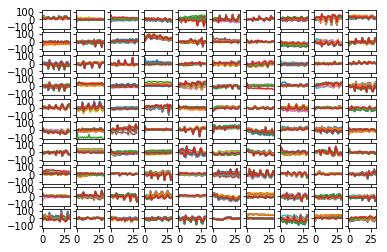

In [2]:
# convert data into frequency (scores) and component profiles (factors) from ICA

from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt

C = 100 # number of features
testID = np.arange(0, y.shape[0], dtype = 'int')
    
ica = FastICA(n_components = C, max_iter = 5000,tol = 0.0001) #tol = 0.001
scores = ica.fit_transform(X_all) #pull components from ica fit transformation
scoreClass = scores[testID]
factors = ica.mixing_
factors = factors.reshape(a, b, C)

I = 10
J = 10

f0, ax = plt.subplots(I, J, sharex = True, sharey = True) #Build a better subplot matrix
for i in range(0, I):
    for j in range(0, J):
        if i*I+j < factors.shape[2]:
            ax[i, j].plot(S_labels['f'], factors[:, :, i*I+j])

plt.show()

0.782893155821


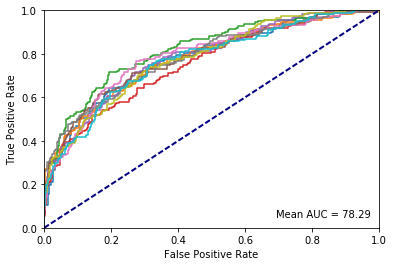

In [3]:
# (1) split scores and labels into training and testing groups
# (2) plot data as boxplots, and difference of the weights between neuron and muscle

from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.metrics import roc_curve, auc

n = 10 # number of folds
F = 1 # number of sets of folds
testAcc = np.zeros((F, n))
fpr = dict()
tpr = dict()
roc_auc = []
s0 = plt.figure()

for fld in range(0,F):
    skf = StratifiedKFold(n_splits = n, shuffle = True)    
    for train_index, test_index in skf.split(scoreClass, y):
        X_train, X_test = scoreClass[train_index], scoreClass[test_index]
        y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
        clf = svm.SVC(kernel = 'linear', class_weight = 'balanced', probability = True)
        y_score = clf.fit(X_train, y_train).decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc.append(auc(fpr, tpr))
        plt.plot(fpr, tpr, lw = 1.5)
        
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(np.mean(roc_auc))
    plt.text(0.975, 0.05, 'Mean AUC = %0.2f' % (np.mean(roc_auc)*100), horizontalalignment = 'right')
    plt.show()
s0.savefig('stimAnalysisOutput/ROC.jpg')

In [4]:
#SwID, LwID, CwID = S_labels['allWindows']['windowID'], L_labels['allWindows']['windowID'], C_labels['allWindows']['windowID']
#wID = np.concatenate((SwID, LwID, CwID))
y_pred=clf.predict_proba(scores)

y_pos = np.zeros((21,360))
for k in np.arange(0, len(S_labels['allWindows']['subject'])):
    d = int(S_labels['allWindows']['subject'][k][6])-1
    w = S_labels['allWindows']['windowID'][k]-1
    if w < 360: 
        y_pos[d, w] = y_pred[k, 1]
        
for k in np.arange(0, len(L_labels['allWindows']['subject'])):
    sham = (int('lm' in L_labels['allWindows']['subject'][k]))
    d = int(L_labels['allWindows']['subject'][k][6])-1
    w = L_labels['allWindows']['windowID'][k]-1
    if w < 360: 
        y_pos[d + 9 + sham*3, w] = y_pred[k + y.shape[0], 1]
        
for k in np.arange(0, len(C_labels['allWindows']['subject'])):
    atrpn = (int('ae' in C_labels['allWindows']['subject'][k]))
    d = int(C_labels['allWindows']['subject'][k][6])-1
    w = C_labels['allWindows']['windowID'][k]-1
    if w < 360: 
        y_pos[d + 15 + atrpn*3, w] = y_pred[k + y.shape[0] + len(L_labels['allWindows']['subject']), 1]
        
t = np.arange(0, 360)
N = 5
wd = np.arange(0, 360-N+1) + (N-2)

grp = [range(0,9), range(9, 12), range(12, 15), range(15, 18), range(18, 21)]
mean = [np.zeros((360)), np.zeros((360)), np.zeros((360)), np.zeros((360)), np.zeros((360))]

for k in range(0,5):
    for d in grp[k]:
        cumsum, moving_aves = [0], []
        for i, x in enumerate(y_pos[d, ], 1):
            cumsum.append(cumsum[i-1] + x)
            if i >= N:
                moving_ave = (cumsum[i] - cumsum[i-N])/N
                moving_aves.append(moving_ave)
        y_pos[d, wd] = moving_aves
    mean[k]=np.mean(y_pos[grp[k], ], axis=0)

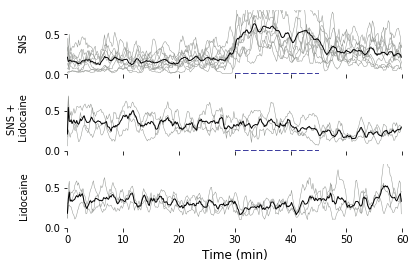

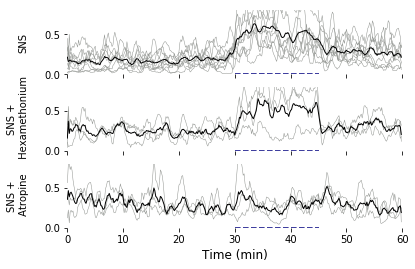

In [5]:
s1, ax=plt.subplots(3, 1, sharex = True, sharey = True)
fntsz='large'
string = ['\nSNS\n', 'SNS +\n Lidocaine\n', '\nLidocaine\n', 'SNS +\n Hexamethonium\n', 'SNS +\n Atropine\n']
for k in range(0, 3):
    for d in grp[k]:
        ax[k].plot(t/6, y_pos[d, ], color='xkcd:grey',
             lw=0.5, linestyle='-')
    ax[k].plot(t/6, mean[k], color='black',lw = 1, linestyle='-')
    if k != 2: ax[k].plot([30, 45], [0, 0], color='navy', lw = 1.5, linestyle='--')
    ax[k].set_ylabel(string[k])
    plt.xlim([0, 60])
    plt.ylim([0, 0.8])      
    ax[k].spines['top'].set_visible(False)
    ax[k].spines['right'].set_visible(False)
    ax[k].spines['bottom'].set_visible(False)
    ax[k].spines['left'].set_visible(False)
    
plt.xlabel('Time (min)',fontsize=fntsz)
s1.savefig('stimAnalysisOutput/Lidocaine_Control.jpg')

s2, ax=plt.subplots(3, 1, sharex = True, sharey = True)
ds = np.array([0, 3, 4], dtype = int)
for k in range(0, 3):
    for d in grp[ds[k]]:
        ax[k].plot(t/6, y_pos[d, ], color='xkcd:grey',
             lw=0.5, linestyle='-')
    ax[k].plot(t/6, mean[ds[k]], color='black',lw = 1, linestyle='-')
    ax[k].plot([30, 45], [0, 0], color='navy', lw = 1.5, linestyle='--')
    ax[k].set_ylabel(string[ds[k]])
    plt.xlim([0, 60])
    plt.ylim([0, 0.8])      
    ax[k].spines['top'].set_visible(False)
    ax[k].spines['right'].set_visible(False)
    ax[k].spines['bottom'].set_visible(False)
    ax[k].spines['left'].set_visible(False)
    
plt.xlabel('Time (min)',fontsize=fntsz)

plt.show()
s2.savefig('stimAnalysisOutput/Cholinergic_Antagonist.jpg')

In [6]:
svdata = np.zeros((26, 360))
header = "s1, s2, s3, s4, s5, s6, s7, s8, s9, sMean, LidoSNS1, LidoSNS2, LidoSNS3, LidoSNSmean, LidoSham1, LidoSham2, LidoSham3, LidoShamMean, Hex1, Hex2, Hex3, HexMean, Atr1, Atr2, Atr3, AtrMean"

svdata[range(0, 9), ] = y_pos[range(0, 9), ]
svdata[9, ] = mean[0]

svdata[range(10, 13), ] = y_pos[range(9, 12), ]
svdata[13, ] = mean[1]

svdata[range(14, 17), ] = y_pos[range(12, 15), ]
svdata[17, ] = mean[2]

svdata[range(18, 21), ] = y_pos[range(15, 18), ]
svdata[21, ] = mean[3]

svdata[range(22, 25), ] = y_pos[range(18, 21), ]
svdata[25, ] = mean[4]

np.savetxt("stimAnalysisOutput/Rate.csv", svdata.T, delimiter=",", header = header)